In [1]:
! pip install yfinance 

     |████████████████████████████████| 6.4 MB 37.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
#from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

In [76]:
import pandas as pd
import yfinance as yf
data_stock = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "TSLA",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "5y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [77]:
data_stock.info()
data_aapl = data_stock.loc[~data_stock.index.duplicated(keep='last')]
data_aapl.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2016-12-23 to 2021-12-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [78]:
data_aapl.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-16,994.500000,994.979980,921.849976,926.919983,27590500
2021-12-17,914.770020,960.659973,909.039978,932.570007,33479100
2021-12-20,910.700012,921.690002,893.390015,899.940002,18826700
2021-12-21,916.869995,939.500000,886.119995,938.530029,23839300
2021-12-22,965.659973,1015.659912,957.049988,1008.869995,30485138


In [79]:
data = data_aapl.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

1007

In [80]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00575656],
       [0.00679331],
       [0.00682848],
       ...,
       [0.72367004],
       [0.75598686],
       [0.81489233]])

In [67]:
x_train = []
y_train = []

for i in range(60, len(scaled_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [68]:
x_train.shape

(1198, 60, 1)

In [69]:
#from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=3)

Epoch 1/3
120/120 [==============================] - 16s 100ms/step - loss: 0.0030
Epoch 2/3
120/120 [==============================] - 10s 81ms/step - loss: 8.1924e-04
Epoch 3/3
120/120 [==============================] - 10s 80ms/step - loss: 7.5858e-04


In [70]:
latest_5_predictions = []

for i in range(5):
    x_test = np.reshape(np.array(scaled_data[-60:]), (1, 60, 1 ))
    predictions = model.predict(x_test)
    scaled_data = np.append(scaled_data,predictions)
    new_value = scaler.inverse_transform(predictions)
    print(new_value[0][0])
    latest_5_predictions.append(new_value)

949.1264
948.53735
948.4413
948.6406
949.02277


In [71]:
new_data = data.reset_index()

In [72]:
new_data['Date'] = new_data['Date'].dt.strftime('%Y-%m-%d')

In [73]:
new_data

,Date,Close
0,2016-12-23,42.667999
1,2016-12-27,43.905998
2,2016-12-28,43.948002
3,2016-12-29,42.936001
4,2016-12-30,42.737999
...,...,...
1253,2021-12-16,926.919983
1254,2021-12-17,932.570007
1255,2021-12-20,899.940002
1256,2021-12-21,938.530029


In [74]:
new_data.to_csv("TSLA_LSTM_5daysprediction.csv",index=False)

### To get MAE 

In [81]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00575656, 0.00679331, 0.00682848, 0.005981  , 0.00581518,
       0.00636789, 0.00804277, 0.00800257, 0.00838109, 0.00876129,
       0.00852513, 0.00850169, 0.00847824, 0.00984494, 0.00948149,
       0.00994711, 0.01085154, 0.01101401, 0.01171578, 0.01266879,
       0.01264534, 0.01231706, 0.01239076, 0.01200218, 0.01221992,
       0.01176938, 0.01215627, 0.01211943, 0.01319805, 0.01314948,
       0.01391992, 0.01511244, 0.01511746, 0.0170218 , 0.01708544,
       0.01688111, 0.01507056, 0.01561992, 0.01648416, 0.01583431,
       0.01289992, 0.01306908, 0.01126524, 0.01189499, 0.01190002,
       0.01197706, 0.01215962, 0.01209933, 0.01166051, 0.01137243,
       0.01104248, 0.01083982, 0.01125519, 0.01323657, 0.01285637,
       0.0139149 , 0.01382278, 0.01389312, 0.01201056, 0.01273578])]
[0.012697260662459589]

[array([0.00575656, 0.00679331, 0.00682848, 0.005981  , 0.00581518,
       0.00636789, 0.00804277, 0.00800257, 0.00838109, 0.00876129,
       0.00852513, 0.00850169, 0.0

In [82]:
#from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=10, epochs=3)

Epoch 1/3
95/95 [==============================] - 11s 79ms/step - loss: 8.7526e-04
Epoch 2/3
95/95 [==============================] - 8s 80ms/step - loss: 3.1165e-04
Epoch 3/3
95/95 [==============================] - 8s 81ms/step - loss: 2.2406e-04


In [83]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the  mean absolute error (MAE)
mae = np.mean(np.abs(predictions - y_test))
mae

49.969038883528384

#PLOT

In [ ]:
df = pd.read_csv("AMZN plot.csv")
df.tail()

,Date,Close,New_close
1259,12/20/21,NaN,3473.3801
1260,12/21/21,NaN,3470.6040
1261,12/22/21,NaN,3471.6280
1262,12/23/21,NaN,3475.0706
1263,12/24/21,NaN,3480.0212


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['Date']

0      2016-12-19
1      2016-12-20
2      2016-12-21
3      2016-12-22
4      2016-12-23
          ...    
1259   2021-12-20
1260   2021-12-21
1261   2021-12-22
1262   2021-12-23
1263   2021-12-24
Name: Date, Length: 1264, dtype: datetime64[ns]

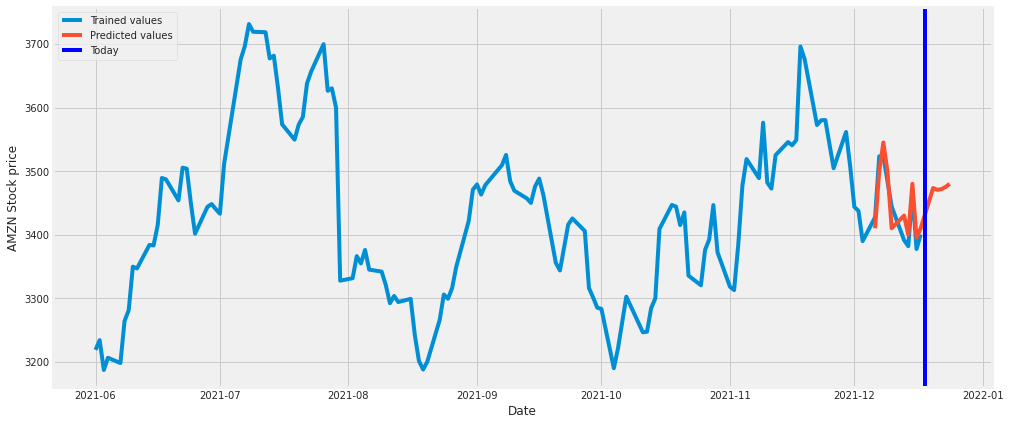

In [ ]:
df_new = df[df['Date']>='2021-06-01']

plt.figure(figsize=(15,7))
plt.plot(df_new['Date'],df_new['Close'],label = "Trained values")
plt.plot(df_new['Date'],df_new['New_close'], label = "Predicted values")
#plt.vlines('2021-12-17')
plt.axvline(x = pd.to_datetime('2021-12-18'), color = 'b', label = 'Today')
plt.xlabel("Date")
plt.ylabel("AMZN Stock price")
plt.legend()

In [ ]:
df.tail(10)

,Date,Close,New_close
1254,2021-12-13,3391.350098,3430.0000
1255,2021-12-14,3381.830078,3400.0000
1256,2021-12-15,3466.300049,3480.0000
1257,2021-12-16,3377.419922,3395.0000
1258,2021-12-17,3400.350098,3410.0000
1259,2021-12-20,NaN,3473.3801
1260,2021-12-21,NaN,3470.6040
1261,2021-12-22,NaN,3471.6280
1262,2021-12-23,NaN,3475.0706
1263,2021-12-24,NaN,3480.0212
